In [2]:
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from mapie.classification import MapieClassifier
from mapie.metrics import (classification_coverage_score,
                           classification_mean_width_score)
import lightgbm as lgb
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import warnings

# Suppress the specific warning
warnings.filterwarnings("ignore", message="X does not have valid feature names")
warnings.filterwarnings("ignore", message="'force_all_finite' was renamed to 'ensure_all_finite'")


# Load Covertype dataset (7 classes)
covertype = fetch_openml(name='covertype', version=4, as_frame=False)
X, y = covertype.data, covertype.target

# Convert the data to pandas DataFrame to handle NaN values
X_df = pd.DataFrame(X)
y_df = pd.DataFrame(y)

# Drop rows with NaN values in both X and y
X_df_cleaned = X_df.dropna()
y_df_cleaned = y_df.loc[X_df_cleaned.index]  # Ensure y corresponds to the rows that remain

# Convert the cleaned DataFrames back to numpy arrays
X_cleaned = X_df_cleaned.values
y_cleaned = y_df_cleaned.values

# Subset for faster execution (optional)
X_cleaned, y_cleaned = X_cleaned[:500000], y_cleaned[:500000]  # Use first 500K samples

# Split data
X_train, X_test, y_train, y_test = train_test_split(X_cleaned, y_cleaned, test_size=0.2, random_state=42)


X_calib = X_train[-1000:]  # Last 1K samples for calibration
y_calib = y_train[-1000:]

X_train = X_train[:-1000]  # Remaining for training
y_train = y_train[:-1000]

#Here initially there as a character array, so we convert it to int
y_train = y_train.astype(int)
y_calib = y_calib.astype(int)
y_test = y_test.astype(int)

#These modifications are done so that the MAPIE functions for mean prediction size and coverage calculations can be done effectively
y_train = y_train -1
y_calib = y_calib -1
y_test = y_test -1

y_train = np.squeeze(y_train)
y_calib = np.squeeze(y_calib)
y_test = np.squeeze(y_test)


In [3]:

# Initialize and train GaussianNB
gnb = GaussianNB()
gnb.fit(X_train, y_train)

# Predictions and Evaluation
y_pred = gnb.predict(X_test)
print("Gaussian Naive Bayes Results")
print("Accuracy:", 100*accuracy_score(y_test, y_pred))


Gaussian Naive Bayes Results
Accuracy: 48.744


In [4]:

# Initialize LightGBM classifier
lgb_classifier = lgb.LGBMClassifier(
    objective='multiclass',
    num_class=len(set(y)),  # 7 classes in the Covertype dataset
    max_depth=10,
    learning_rate=0.15,
    n_estimators=100,
)

# Train the model
lgb_classifier.fit(X_train, y_train)

# Make predictions
y_pred = lgb_classifier.predict(X_test)

# Evaluate the results
print("LightGBM Results")
print("Accuracy:", 100*accuracy_score(y_test, y_pred))


[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.004673 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2267
[LightGBM] [Info] Number of data points in the train set: 399000, number of used features: 52
[LightGBM] [Info] Start training from score -1.047648
[LightGBM] [Info] Start training from score -0.683172
[LightGBM] [Info] Start training from score -2.876736
[LightGBM] [Info] Start training from score -5.196421
[LightGBM] [Info] Start training from score -3.989511
[LightGBM] [Info] Start training from score -3.514105
[LightGBM] [Info] Start training from score -3.378818
LightGBM Results
Accuracy: 86.447


In [5]:
alpha = np.linspace(0.01, 0.5, 50)

In [6]:
mapie_gnb = MapieClassifier(estimator=gnb, method="lac", cv="prefit") 
mapie_gnb.fit(X_calib, y_calib)
act_pred_gnb, pred_set_gnb = mapie_gnb.predict(X_test, alpha=alpha)

In [7]:
mapie_lgm = MapieClassifier(estimator=lgb_classifier, method="lac", cv="prefit") 
mapie_lgm.fit(X_calib, y_calib)
act_pred_lgm, pred_set_lgm = mapie_lgm.predict(X_test, alpha=alpha)

In [8]:
coverages_score_gnb = [classification_coverage_score(y_test, pred_set_gnb[:, :, i]) for i, _ in enumerate(alpha)]
widths_score_gnb = [classification_mean_width_score(pred_set_gnb[:, :, i]) for i, _ in enumerate(alpha)]

coverages_score_lgm = [classification_coverage_score(y_test, pred_set_lgm[:, :, i]) for i, _ in enumerate(alpha)]
widths_score_lgm = [classification_mean_width_score(pred_set_lgm[:, :, i]) for i, _ in enumerate(alpha)]


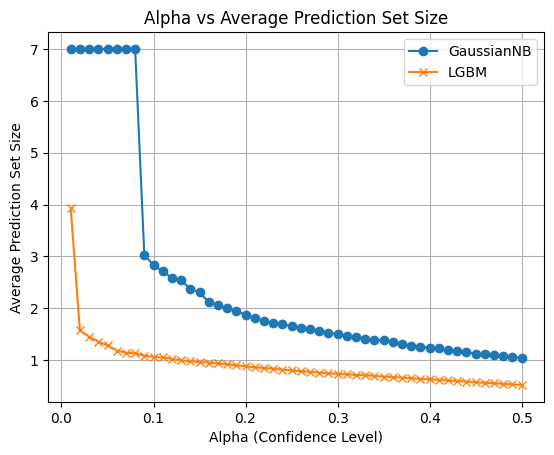

In [16]:
plt.plot(alpha, widths_score_gnb, label='GaussianNB', marker='o')
plt.plot(alpha, widths_score_lgm, label='LGBM', marker='x')

# Adding labels and title
plt.xlabel('Alpha (Confidence Level)')
plt.ylabel('Average Prediction Set Size')
plt.title('Alpha vs Average Prediction Set Size')

# Display legend
plt.legend()

# Adding grid
plt.grid(True)

# Show the plot
plt.show()

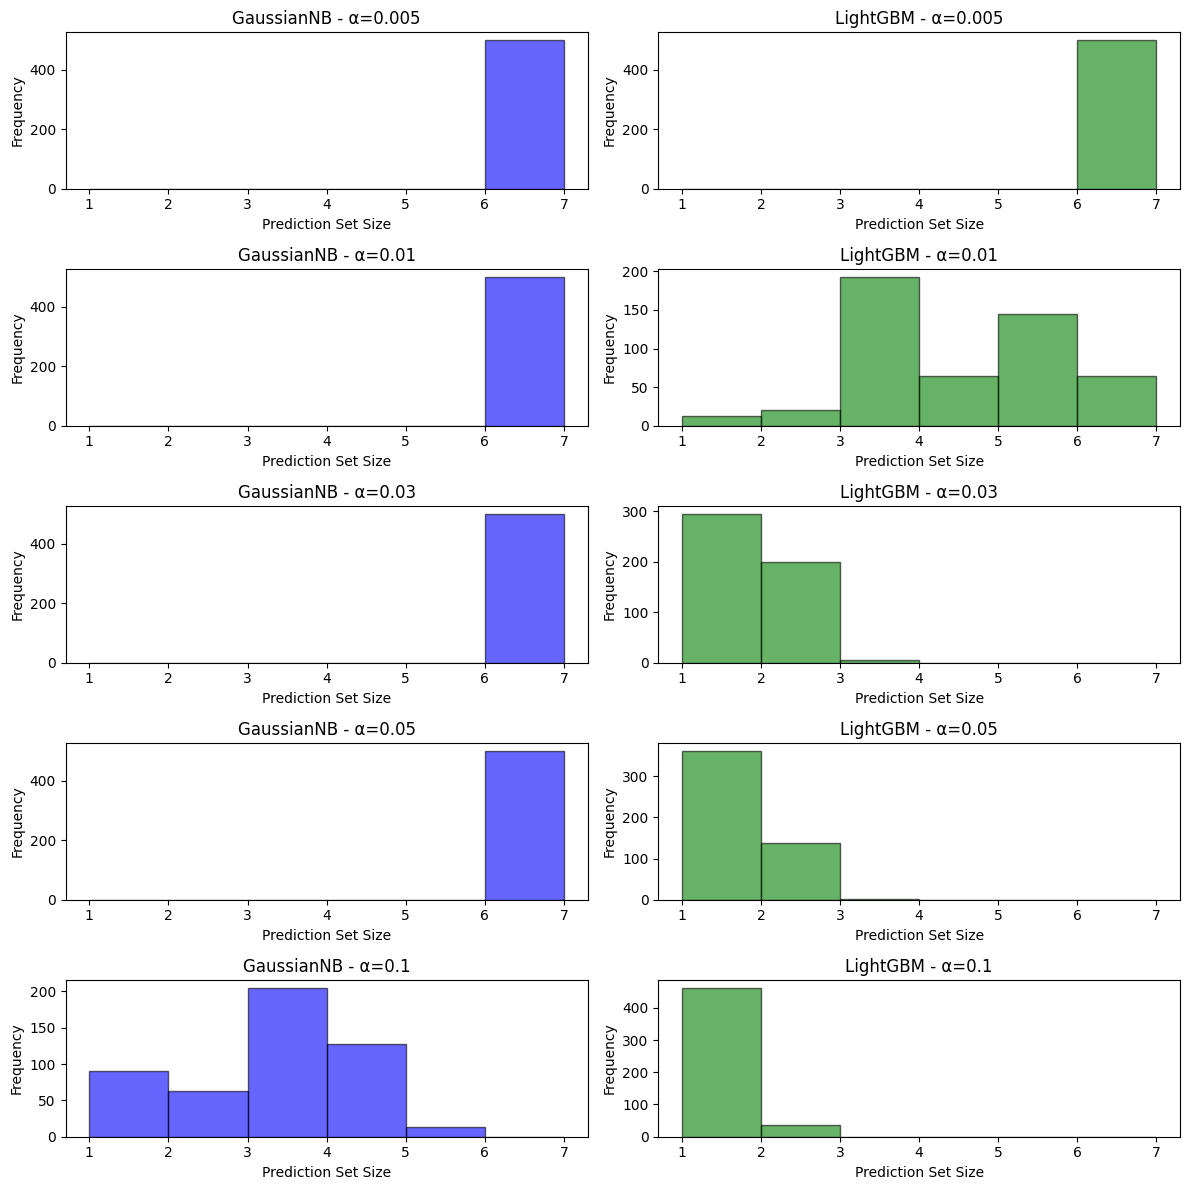

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Testing for various values of alpha
alpha_values = [0.005, 0.01, 0.03, 0.05, 0.1]

num_samples = 500

fig, axes = plt.subplots(len(alpha_values), 2, figsize=(12, 12))

for i, alpha_val in enumerate(alpha_values):
    # Predictions
    _, pred_set_gnb = mapie_gnb.predict(X_test, alpha=[alpha_val])
    _, pred_set_lgm = mapie_lgm.predict(X_test, alpha=[alpha_val])
    
    # Randomly sampling
    random_indices = np.random.choice(len(X_test), num_samples, replace=False)

    # Compute set sizes
    set_sizes_gnb = [np.sum(pred_set_gnb[idx, :, 0]) for idx in random_indices]
    set_sizes_lgm = [np.sum(pred_set_lgm[idx, :, 0]) for idx in random_indices]

    # Plot GaussianNB histogram
    axes[i, 0].hist(set_sizes_gnb, bins=range(1, 8), alpha=0.6, color='blue', edgecolor='black')
    axes[i, 0].set_xlabel("Prediction Set Size")
    axes[i, 0].set_ylabel("Frequency")
    axes[i, 0].set_title(f"GaussianNB - α={alpha_val}")

    # Plot LightGBM histogram
    axes[i, 1].hist(set_sizes_lgm, bins=range(1, 8), alpha=0.6, color='green', edgecolor='black')
    axes[i, 1].set_xlabel("Prediction Set Size")
    axes[i, 1].set_ylabel("Frequency")
    axes[i, 1].set_title(f"LightGBM - α={alpha_val}")

plt.tight_layout()
plt.show()


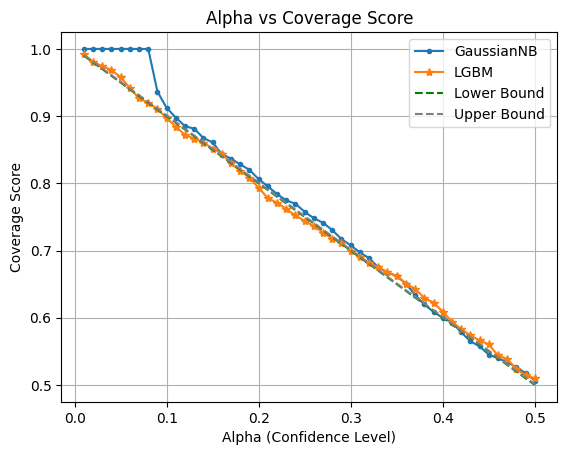

In [ ]:
lower_coverage = [1-x for x in alpha]
upper_coverage = [1-x + 0.001 for x in alpha]
plt.plot(alpha, coverages_score_gnb, label='GaussianNB', marker='.')
plt.plot(alpha, coverages_score_lgm, label='LGBM', marker='*')
plt.plot(alpha, lower_coverage, label='Lower Bound', linestyle='--', color='green')
plt.plot(alpha, upper_coverage, label='Upper Bound', linestyle='--', color='gray')
# Adding labels and title
plt.xlabel('Alpha (Confidence Level)')
plt.ylabel('Coverage Score')
plt.title('Alpha vs Coverage Score')
# Display legend
plt.legend()
# Adding grid
plt.grid(True)
# Show the plot
plt.show()
